In [17]:
# Работа с данными и визуализация
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Модели машинного обучения для временных рядов
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Исследование и анализ временного ряда + визуализация
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Метрики для оценивания качества модели 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Методы построения моделей временных рядов (с помощью библиотеки skforecast)
#from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

# Настройка стилей отображеня графиков для визуализации
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'

c:\Users\lucas\Desktop\COURSES\SCIENCE_PROJECTS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
else:
    print("CUDA is not available. PyTorch will use the CPU.")


CUDA is available. PyTorch can use the GPU.


In [1]:

import tensorflow as tf

# Perform a simple operation to confirm GPU usage
tf.debugging.set_log_device_placement(True)

# Example operation
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
c = tf.matmul(a, b)
print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [2]:
print(tf. config. list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Первичный анализ и просмотр данных

In [19]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df.drop(['store', 'product'], axis = 1, inplace = True)
test.drop(['store', 'product'], axis = 1, inplace = True)

In [20]:
print(df.shape)
df.head()

(230090, 2)


,Date,number_sold
0,2010-01-01,801
1,2010-01-02,810
2,2010-01-03,818
3,2010-01-04,796
4,2010-01-05,808


Временной ряд - это последовательность хронологически упорядоченных данных, расположенных через равные или неравные интервалы. Процесс прогнозирования состоит из прогнозирования будущего значения временного ряда либо путем моделирования ряда исключительно на основе его поведения в прошлом (авторегрессия) либо с использованием других внешних переменных

In [5]:
df.dtypes

Date           object
number_sold     int64
dtype: object

Дата была сохранена в виде строки. Чтобы преобразовать в datetime, будем использовать pandas

In [6]:
# Преобразуем столбец data  в тип данных datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# Индекс - дата
df.index = df['Date']
# Убираем имя индекса
df.index.name = None

# Удаляем столбец с датой (так как он оказывается дублирующим)
df.drop('Date', axis = 1, inplace = True)

In [7]:
df.head()

,number_sold
2010-01-01,801
2010-01-02,810
2010-01-03,818
2010-01-04,796
2010-01-05,808


### Изменение шага (агрегация по дню)

Так как мы удалили значение магазина и определенного товара, то у нас остались повторяющие значения даты, поэтому нам надо провести агрегацию в даных по дням (и взять сумму количества продаж в этот день)

In [8]:
df = df.resample(rule = 'D').sum()
df.head()

,number_sold
2010-01-01,54870
2010-01-02,54960
2010-01-03,54863
2010-01-04,54926
2010-01-05,54634


### Расчет скользящего среднего

Скользящее среднее используется для сглаживания данных и выявления общих трендов. Оно представляет из себя усреднение последовательных подмножеств данных во временном ряду, чтобы уменьшить шум и выявить общие паттерны в данных

Скользящее среднее разсчитывается для определенного окна (window) которое задает сам пользователь при расчете скользящего среднего (moving average)

То есть **для каждого окна вычисляется среднее значение и далее происходит пережвидение окна на одну позицию вперед**

Чем больше значение окна - тем больше сглаживаются данные (можно выявить таким образом тренд в данных)

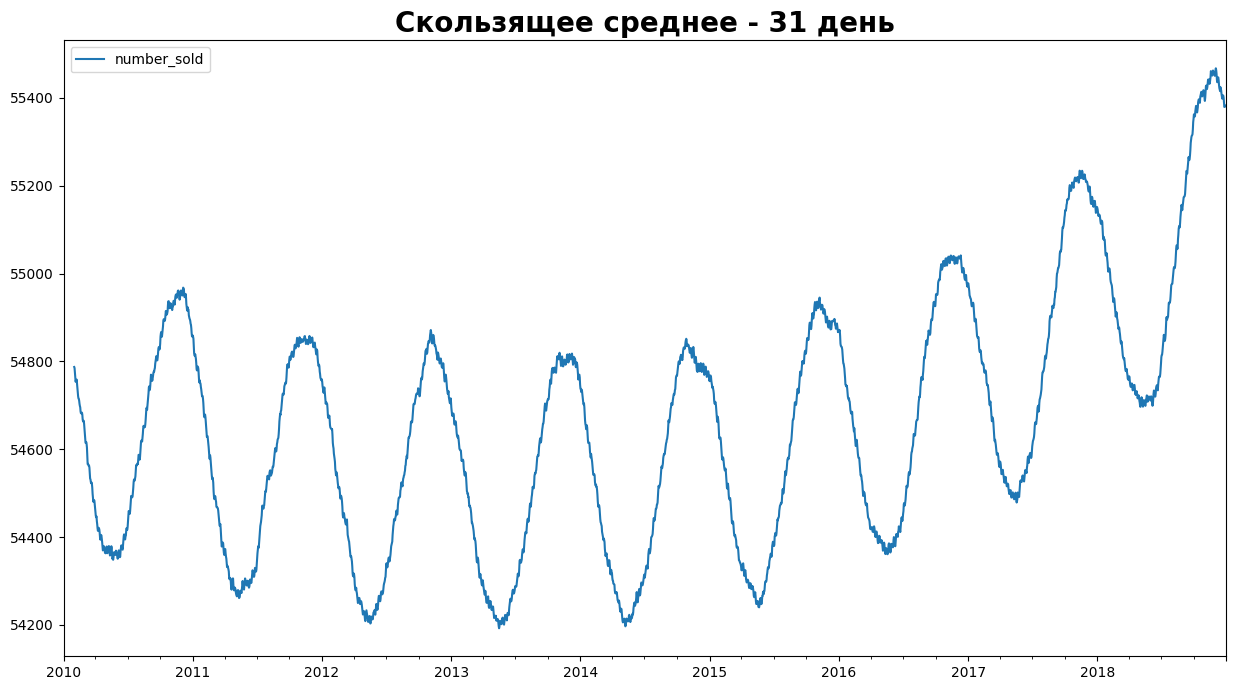

In [9]:
df.rolling(window = 31).mean().plot()
plt.title('Скользящее среднее - 31 день')
plt.show()

В качестве размера окна было выбрано значение - 31. Это означает, что данные временного ряда усредняются за 31 день и тем самым происходит сглаживаение и более видны колебания. То есть мы усредняем количество продаж по месяцам и смотрим среднее значение выручки

Так на этом графике мы видим:
1. Ряд нестационарный
2. Присутствует сезонность
3. Проявтяется тренд (но это стоит еще проверить)

По поводу сезонности:
1. На начало года приходит пик продаж - то есть скорее всего это из за новогодних праздников и распродаж, которые как раз прихоядстя на начало года.
2. Спад происходит на середине года - то есть на летний период времени. И ближе к концу года снова начинается увеличение продаж
3. Так происходит каждый год

Построим скользящее среднее с окном 365 - то есть усредним за год и посмотрим как исзменяется с каждым годом тренд в продажах магазина

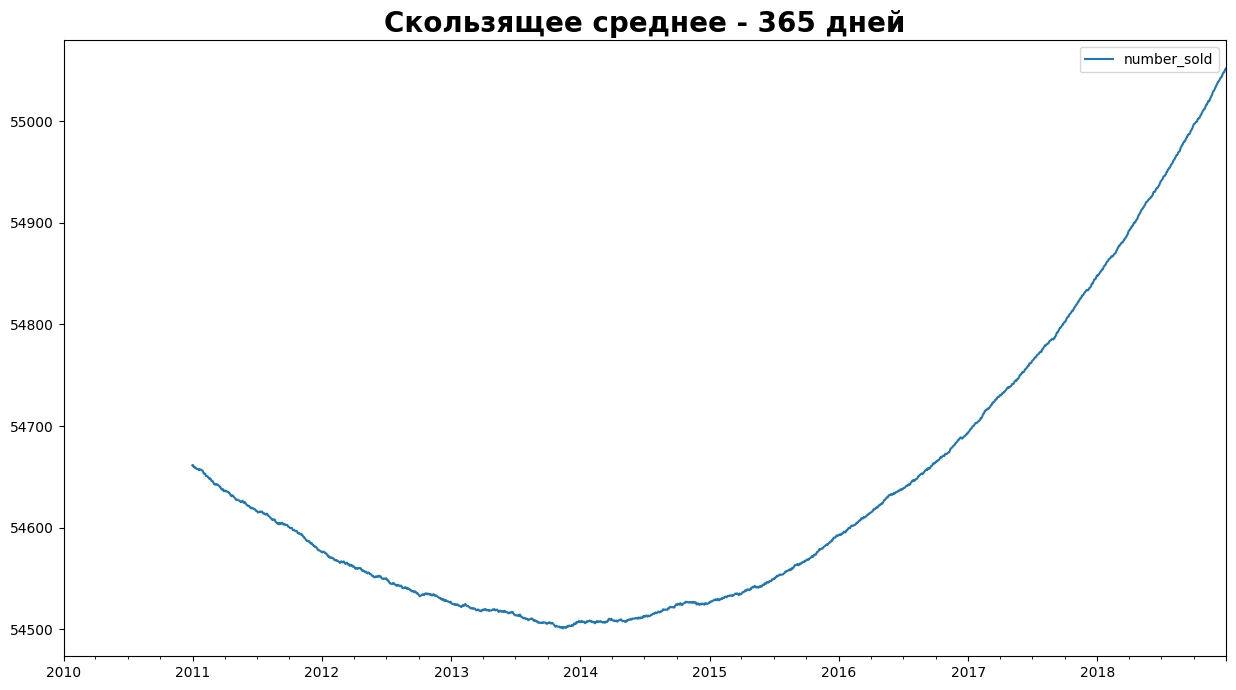

In [10]:
df.rolling(window = 365).mean().plot()

plt.title('Скользящее среднее - 365 дней')
plt.show()

1. Начало продаж магазина началоь с 2011 года (сначала года)
2. Меньше всего продаж приходится на начало 2014 года
3. После 2014 года объем продаж в магазине с каждым годом начали расти

### Просмотр значений NaN в тренировочном

In [11]:
df.isna().sum()

number_sold    0
dtype: int64

Количество значений `NaN` в наборе данных равен 0 -> в наборе данных не будет производиться заполнение проупсков

Но существует несколько методов заполнения значений nan во временных рядых:
1. `ffill` - заполняет значением, которое расположено перед NaN
2. `bfill` - заполняет значением, которое расположено после NaN
3. `sample.opiginal.interpolate(method = 'linear')` - заполняет основываясь на линейной интерполяции - то есть предполагает что между двумя известными точками данные изменяются линейно, таким образом данные NaN заполняются значениями, которые лежат на линии между двумя известными значениями
4. `sample.opiginal.interpolate(method = 'nearest')` - использует для заполнения ближайшее доступное значение

Но так как в данных нет значений `NaN` - ни один из этих методов применять в данной работе не будет 

### Разложение временного ряда на компоненты

Декомпозиция временного ряда - это процесс разделения временного ряда на его основные компоненты - тренд, сезонность, остатки

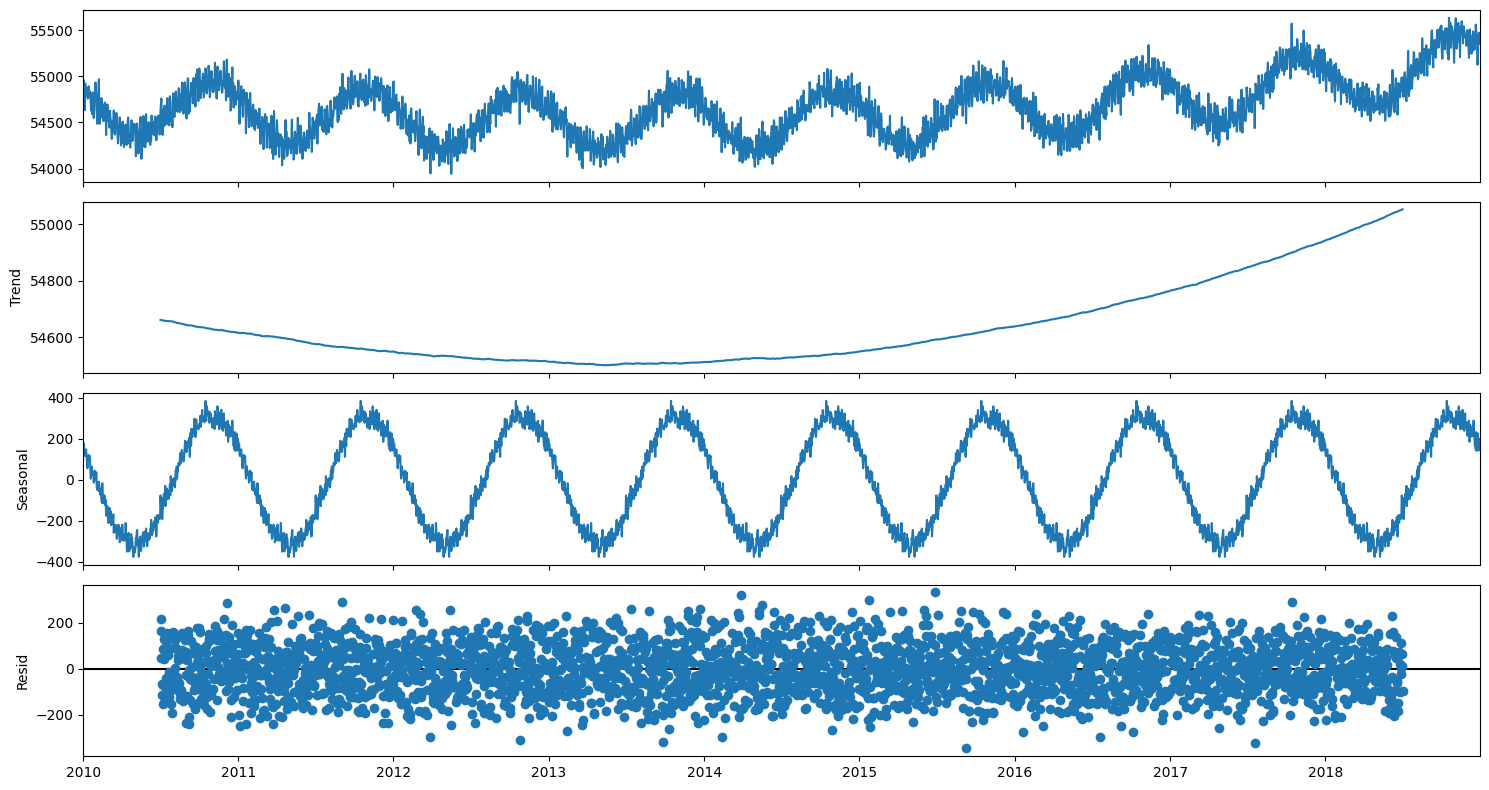

In [12]:
seasonal_decompose(df, model = 'additive', period = 365).plot()
plt.show()

На данном графике мы разложили наш временной ряд на компоненты
1. График нашего временного ряда (исходный временной ряд)
2. График тренда - долгосрочная тенденция в данных, которая сглаживает короткие промежутки в данных
3. График сезонности - отрадает регулярно повторяющиеся колебания в данных
4. График остатков -  граифик остатков представляет собой остаток данных, которые не объясняются ни трендом ни сезонностью

В качестве параметра настройки графика мы взяли аддитивную модель временного ряда (то есть временной ряд представляется как сумма всех компонент временного ряда - тренд сезонность и остатки), то есть в аддитивном временном ряду колебания постоянные

В то вемя как в мультипликативном временном ряду - колебания увеличиваются относительно времени (то есть чем больше времени проходит, тем больше станосится аплитуда в колебаниях)

**Аддитивность - сумма тренда сезонности и остатков (колебания постоянные)**
**Мультипликативность - произведение тренда сезонности и остатков (колебания увеличиваются)**

И так же настроили период - 365, то есть сделали скользящее среднее для тренда в 365 дней (годовое окно) чтобы сгладить данные и посмотреть как количество продаж изменяется со временем (интерпретацию по сезонности и тренду можно посмотреть и почитать выше)

### Проверка временного ряда на стационарность

Стационарность - компоненты таике как тренд, сезонность - отсутствуют. То есть среднее значение и дисперсия не меняются со смещением во времени.

Стационарность можно оценить визуально (то есть если тренд и сезонность значит ряд - нестационарный), а можно использовать оценку Дики Фуллера - и сомтреть значение p_value для принятия гипотезы либо о нестационарности (нулевая) либо стационарности (альтернативная)

**p_value - если значение < заданного критерия - то отвергаем нулевую гипотезу, иначе не отвергаем**

Исходя из визуализации и декомпозиции временного ряда (визуализация которой представлена выше) - мы имеем нестационарный временной рад (так как есть такие компоненты как сезонность и тренд)

Но мы так же проверим временной ряд статистически (с использование теста Дики Фуллера) и сделаем вывод и типе временного ряда (стационарный или нет)

In [13]:
# Тест Дики Фуллера
p_value = adfuller(df)[1]
print('p_value --', round(p_value,3))

p_value -- 0.108


Так как значение p_value - больше заданного уровня значимости (0,05) мы не можем отвергнуть нулевую гипотезу и ряд является нестационарным (что и было видно при визуализации временного ряда и при разложении его на компоненты)

### График автокорреляции

автокорреляция - показывает степень взаимодействия - только не между двумя переменными, а между одной и той же, только в разные моменты времени

In [14]:
# Создадим несколько переменных с разными лагами 
for i in range(1,8):
    string = f'lag{i}'
    df[string] = df['number_sold'].shift(i, axis = 0)

df.head(11)

,number_sold,lag1,lag2,lag3,lag4,lag5,lag6,lag7
2010-01-01,54870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,54960,54870.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,54863,54960.0,54870.0,NaN,NaN,NaN,NaN,NaN
2010-01-04,54926,54863.0,54960.0,54870.0,NaN,NaN,NaN,NaN
2010-01-05,54634,54926.0,54863.0,54960.0,54870.0,NaN,NaN,NaN
2010-01-06,54920,54634.0,54926.0,54863.0,54960.0,54870.0,NaN,NaN
2010-01-07,54853,54920.0,54634.0,54926.0,54863.0,54960.0,54870.0,NaN
2010-01-08,54791,54853.0,54920.0,54634.0,54926.0,54863.0,54960.0,54870.0
2010-01-09,54836,54791.0,54853.0,54920.0,54634.0,54926.0,54863.0,54960.0
2010-01-10,54872,54836.0,54791.0,54853.0,54920.0,54634.0,54926.0,54863.0


Выделили лаг - то есть сделали задержку во времени, лаг сделали равным от 1 до 7 (то есть присутствует недельный диапазон значений) - известны цены за прошлую неделю 

Лаг во времени - это значение, взятое с некоторым интервалом из прошлого

**Для чего нужен лаг:**
1. Лаг нужен для того, чтобы понимать как предыдущие значения влияют на текущее значение (это поможет при прогнозировании временных рядов)
2. Лаг таке используется для определения автокорреляции (которая выполняет ту же функцию, описаннуую в 1 пункте)

Построим классическую матрицу корреляции для набора данных выше

<Axes: >

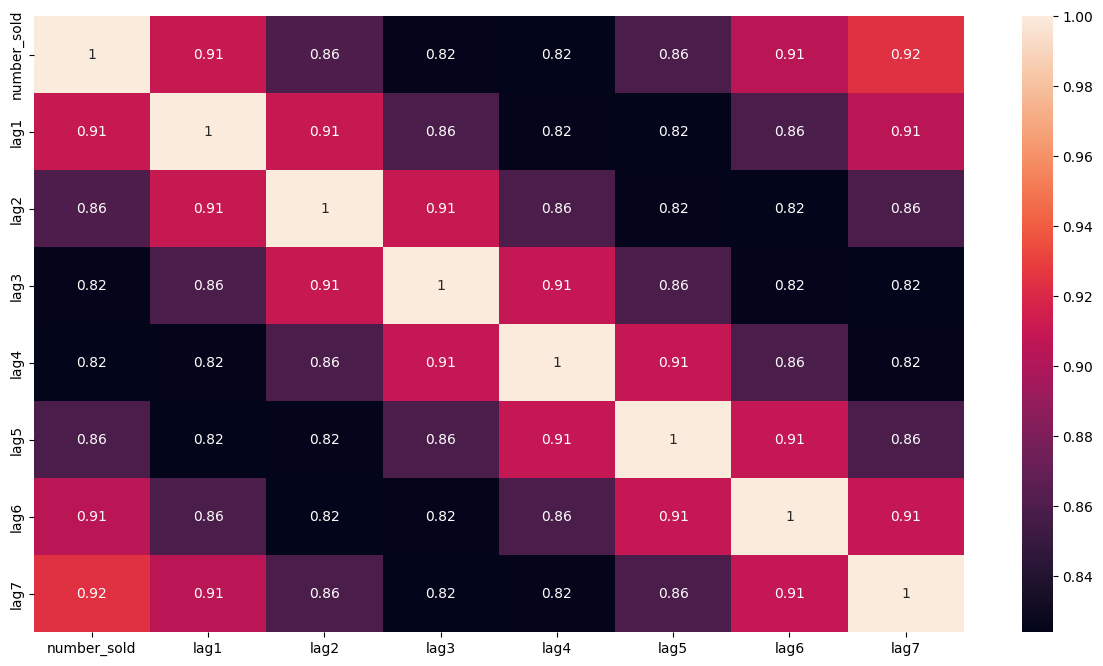

In [15]:
correlation = round(df.corr(),3)
sns.heatmap(correlation, annot = True)

В данной матрице корреляции только 7 лагов - далее мы построим другой график и посмотрим на все остальные лаги

Если интерпертировать данный график то у нас есть наша целевая переменна - `number_sold` (количество продаж), а остальыне столбцы - это сдвиг во времени (то есть лаг)

Например можно заметить сильную связь целевой переменной и lag1 и lag7 
1. Целевое значение сильно взаимосвязано с предыдущим значением продаж (то есть сколько продали в предыдущий день)
2. Целевое значение сильно коррелирует с `lag7` то есть текущее значение сильно связано с тем, сколько было продано неделью назад (сезонность)


In [16]:
df.drop(list(df.columns[1:]), axis = 1, inplace = True)

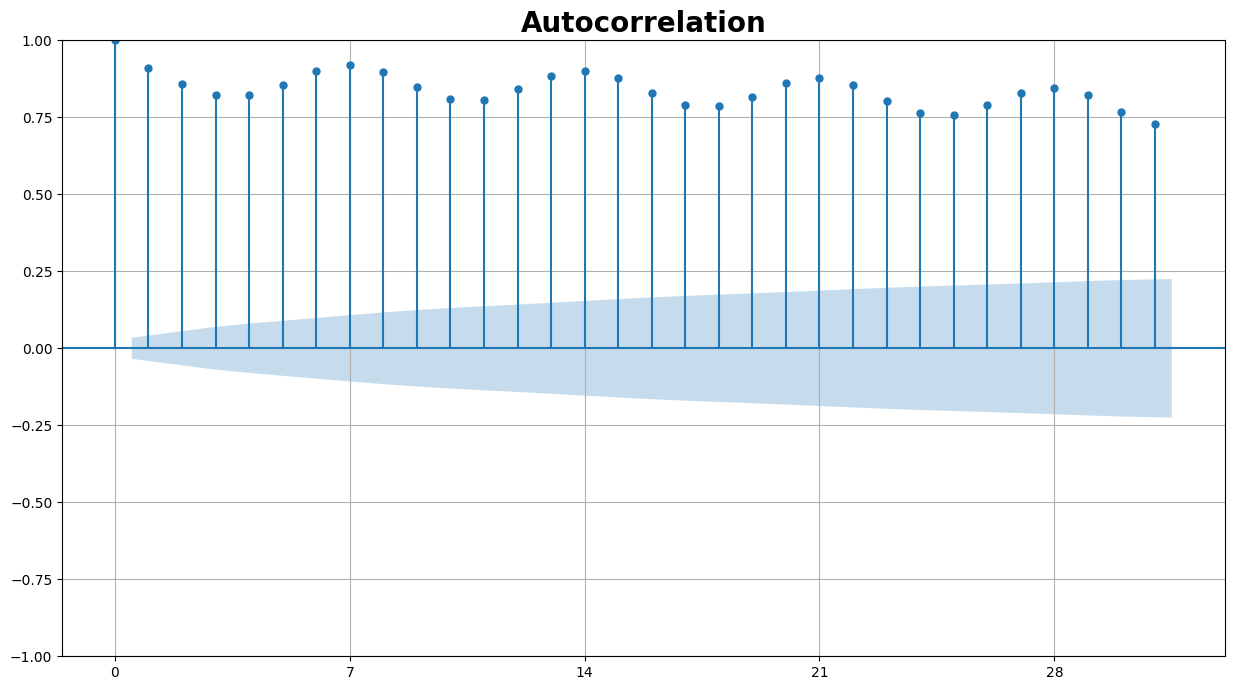

In [17]:
# Построим график ACF - график автокорреляции 
plot_acf(df, lags = 31)
plt.xticks(range(0,32, 7))
plt.grid(True)
plt.show()

Данный график - график автокорреляционной функции - он позволяет выявить тренд и сезонность в данных.

1. В данной графике мы видим, что 7 значение больше всего коррелирует с целевым признаком - это означает что 7 лаг (как и выводилось ранее на предыдущем графике) больше всего оказывает влияние на целевую переменную, то есть что значит что 7 лаг оказывает большее вличение.

Это означает что значение количества продаж которое было на предыдущей неделе (то есть как раз с отстованием в 7 дней) лучше всего связано с текущим значением признака

2. Так же стоит заметить что корреляция полодительная, следовательно существует тренд 
3. Синяя граница графика - статистическая значимость коэффициента корреляции, если актокорреляция выходит за пределы этой синей области - то автокорреляция является достаточно сильной и ее можно использовать при построении моделей (как обычных так и статистических)

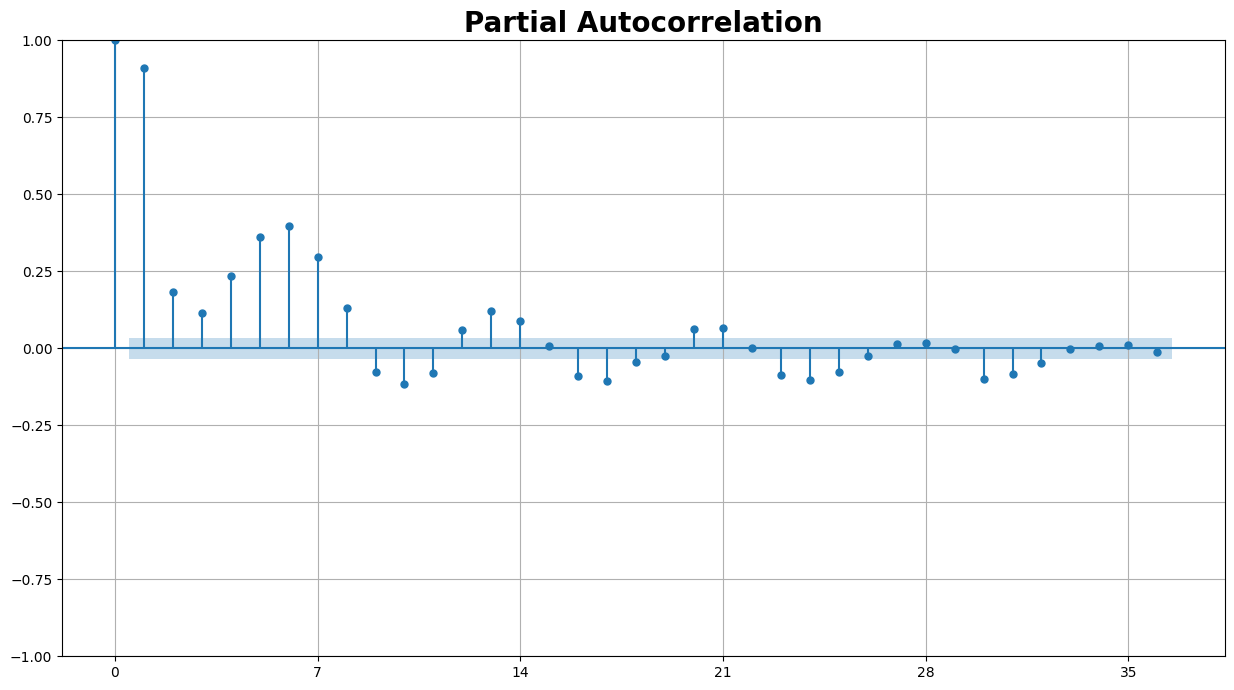

In [18]:
plot_pacf(df)
plt.xticks(range(0,40,7))
plt.grid(True)
plt.show()

PACF - график частичной автокорреляционной функции.

Отличие от обычного автокорреляционного графика заключаются в следующем:
1. измеряет корреляцию между целевым значением и лагом после исключения влияния промежуточных лагов (которые стояли между этим лагом и целевым значением)
2. Применяется для измерения порядка авторегрессии

Значимые лаги на данном графике - 1 лаг и 6 лаг

**Вывод по двум графикам:**
1. Так как на графике ACF - значимые лаги - 7 14 21 (то есть каждая неделя) - это указывает на наличие недельной сезонности в данных
2. Наиболее значимо целевое значение коррелирует с лагами 1 и 6 - это мы видим на графике PACF
3. Оба графика укзывают на сезонность в данных (ACF) и авторегрессию (то есть зависимость между целевой и лагом - PACF)

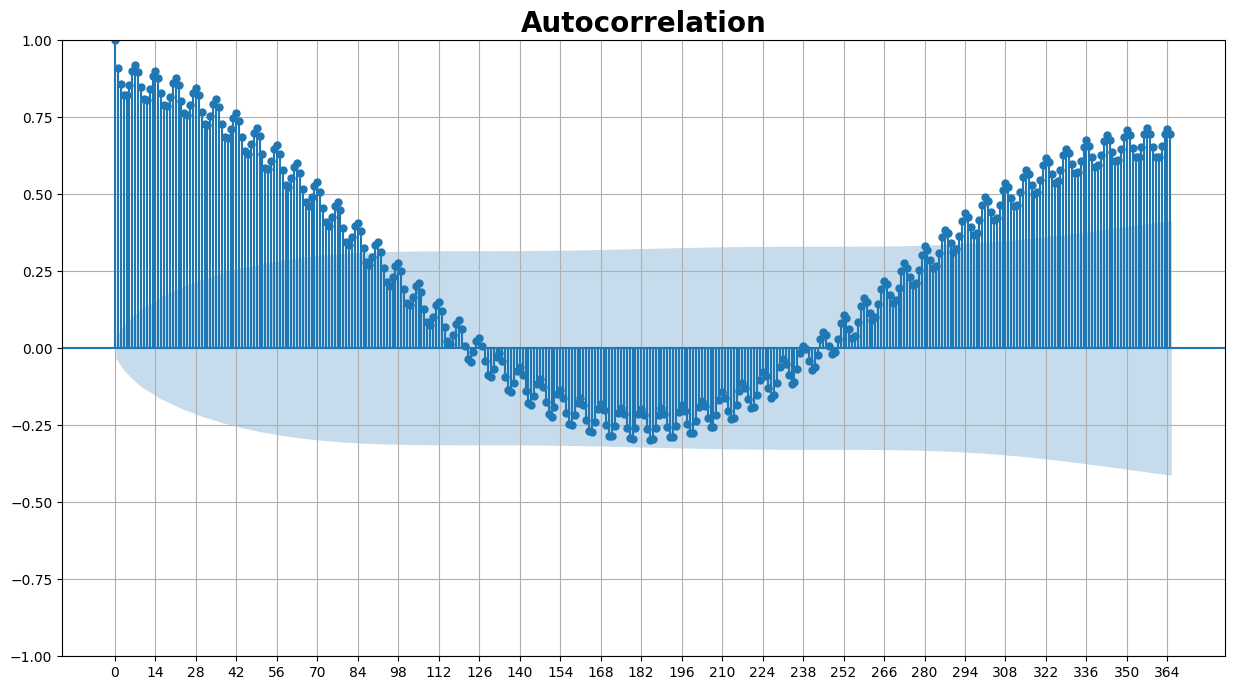

In [19]:
# Построим график ACF - график автокорреляции 
plot_acf(df, lags = 365)
plt.xticks(range(0,366, 14))

plt.grid(True)
plt.show()

Данный график построен для определения автокорреляции за целый год (то есть выбран лаг 365 дней)

Можно заметить что боьлше всего целевое значение коррелирует с ближайшим значением недели, а по мере удаления недели (то есть 14 и так далее лаги) - или если сказать по другому, больше всего нам поможет значение либо следующего дня либо значение ближайшей недели, в то время как по мере удаления недель корреляция слабеет и примерно в середине года (то есть с 98 дня по 280 день) корреляция вообще оаказывается незначимой

Но так же можно заметить что присутствует как недельный тренд, так и годовой тренд

То есть после определенного значения (на данном графике - это значение 266 дня) корреляция снова становиться значимой и коэффициент корреляции увеличивается после истечения каждой недели и к 364 дню коффициент коррляции снова становиться большим (примерно как и при 7 лаге) что указывает на то, что на целевое значение количества продаж так же влияет количество продаж сделанных в предыдущем году

Значения которые отрицательные в середине года:
1. Отрицательные значения корреляции указывают на то что количество продаж обратно пропорционально продажам в середине года (то есть по мере увеличения количества продаж в середине года - целевая переменная уменьшается)

## Построение статистической модели временного ряда

После анализа данного временного ряда мы сделала несколько выводов по поводу типа временного ряда и его компонент:

1. Временной ряд - нестационарный
2. В данном временном ряду есть сезонность
3. Есть тренд
4. Сезонность есть как годовая, недельная так и дневная (то есть то что произошло за предыдущий день)

С учетом этим характеристик временного ряда мы определили какую модель стоит использовать для прогнозирования занчений

### SARIMA

Использование модели `SARIMA` порисходит по несольким признакам и данная модель подходит по характеристикам в наших данных:
1. Ряд нестационарный
2. Существует сезонность
3. Присутсствует тренд

Почему выбрали данную модель и почему будем ее использовать 
1. Как говорилось ранее данная модель подожит по характеристикам данных которые приведены выше
2. Так как временной ряд нестационарный и модель умеет работать с нестационарным временным рядом и сезонностью то мы и будем ее использовать

Как именно модель умеет работать с нестационарным временным рядом 
1. Так как у модели есть такое параметр d - порядок дифференцирования (то есть сколько раз надо отнять текущее значение от предыдущего) что как раз и приводит нестационарный ряд к стационарному, как раз потому мы и будем использовать модель `SARIMA` потому что она автоматически приведет временной ряд в стационарную форму а потом с помощью параметров авторегрессии и скользыщего среднего
2. Так же есть у модели параметры, которые настраиваются относительно сезонности в данных (P,D,Q,s)
3. Подбор гиперпарамеров будем осуществлять с помощью проделанного анализа и предскажем с помощью данной модели тестовые данные которые были даны изначально

In [20]:
# Преобразование тестового набора данных для предсказания

# Преобразуем столбец data  в тип данных datetime
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')

# Индекс - дата
test.index = test['Date']
# Убираем имя индекса
test.index.name = None

# Удаляем столбец с датой (так как он оказывается дублирующим)
test.drop('Date', axis = 1, inplace = True)

In [21]:
test = test.resample(rule = 'D').sum()
test.head()

,number_sold
2019-01-01,55221
2019-01-02,55287
2019-01-03,55302
2019-01-04,55407
2019-01-05,55289


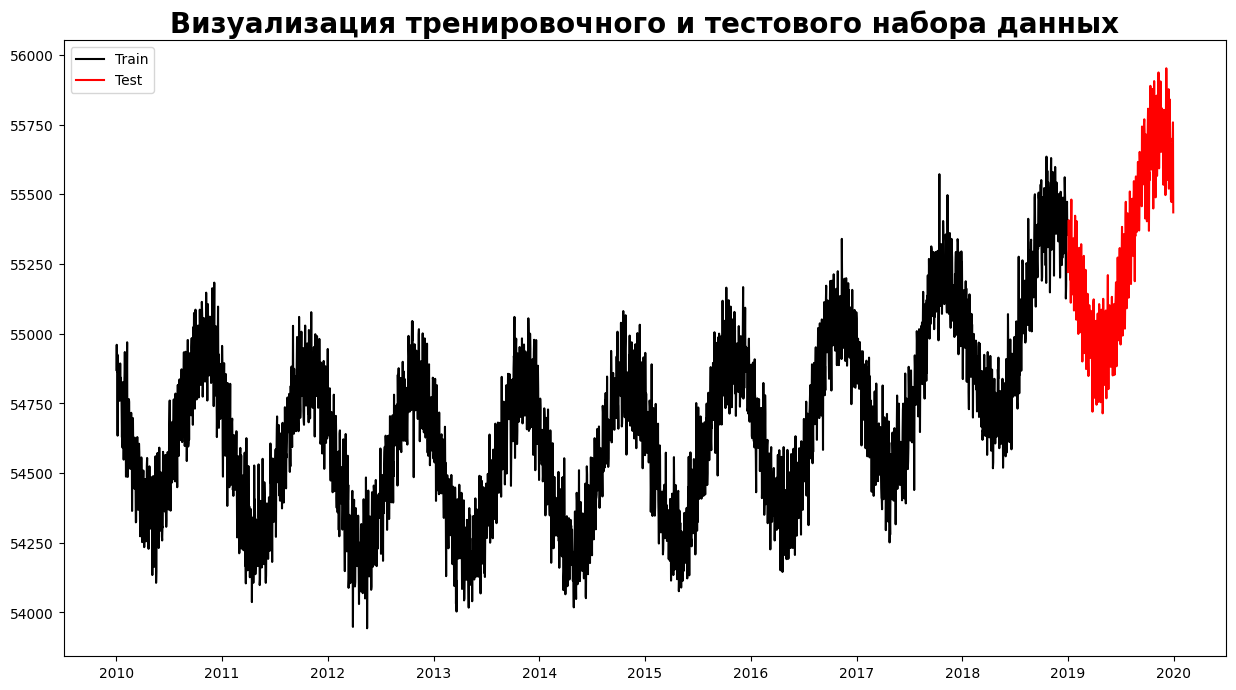

In [22]:
# Визуализация тренировочного и тестового набора данных
train = df.copy()

plt.plot(train, color = 'black', label = 'Train')
plt.plot(test, color = 'red', label = 'Test')
plt.legend()
plt.title('Визуализация тренировочного и тестового набора данных')
plt.show()

Так как модель SARIMA сама преобразовывет нестационарный ряд к стационарности, то нужно подобрать порядок дифференцирования временного ряда (то есть сколько раз вычитать текущее знчений от предыдущего)

Чтобы сделать это, в ручную продифференцируем копию исходного временного ряда и подберем этот параметр (а так же проверим статистически с помощью теста Дики Фуллера на стационарность временного ряда)

Так же стоит отметить что у нас есть 2 набор данных для тренировки модели 
1. `train` - для тренировки моделей временного ряда 
2. `test` - для проверки и оценки построенных моделей

p_value = 3.894249829390843e-10


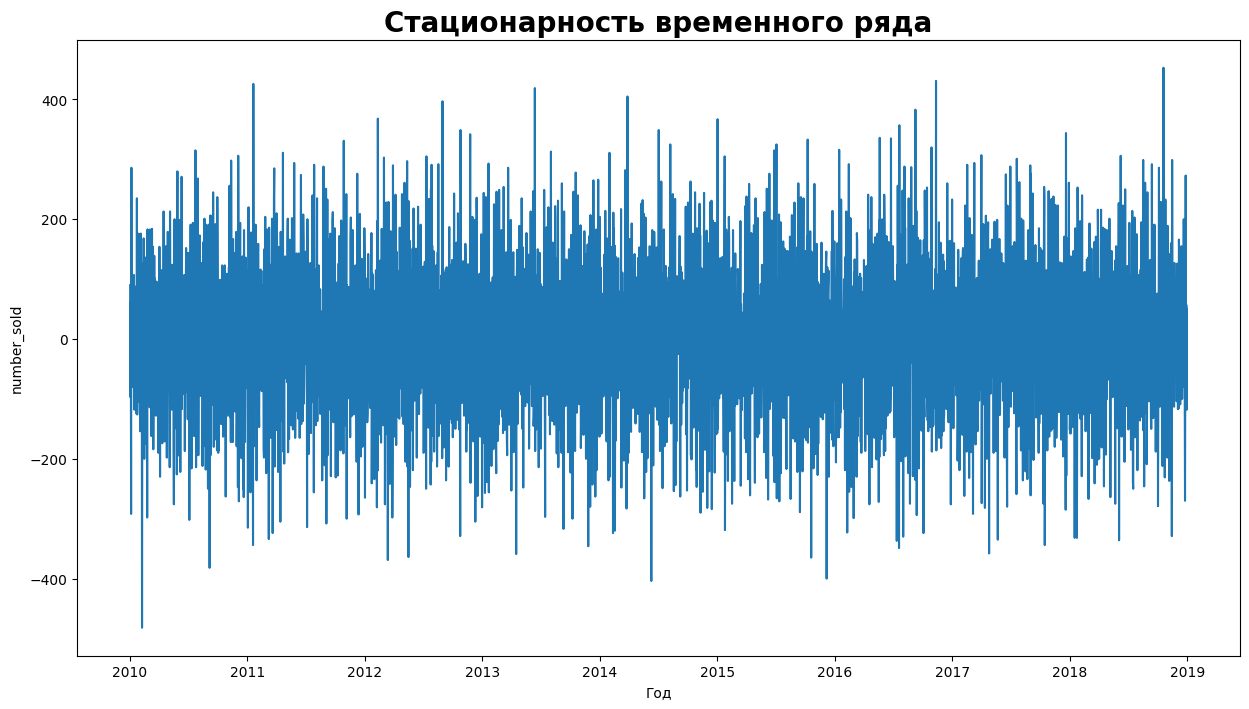

In [23]:
# Подбор порядка дифференцирования
dif = df['number_sold'].diff(periods = 1).dropna()

# Построение графика для визуализации 
sns.lineplot(dif)
plt.title('Стационарность временного ряда')

plt.xlabel('Год')
plt.plot()

# Статистическая проверка на стационарность 
adf_test = adfuller(dif)[1]
print('p_value =', adf_test)

как видно по значению p_value которое значительно меня уровня значимости (0.05) -> мы можем отвергнуть нулевую гипотезу (временной ряд нестационарный) и принять альтернативную гипотезу - о том, что временной ряд является стационарным, следовательно 1 порядок диффиринцирования нам подходит для гиперпараметра модели `SARIMA`

После того как мы подобрали один из параметров, который отвечает за преодразование в стационарный временной ряд (в модели этот параметра обозначается как `d`) нам надо подобрать остальные гиперпараметры для модели 

**Какие параметры подбираются дальше:**
1. **p**- авторегрессионная компонента - целое число

Определяет количество предыдущих значений временного ряда, которые будут использоватья для прогнозирования следующего значения

2. **q** - компонента скользящего среднего - целое число

Определяет количество предыдущих ошибок прогнозирования, которые будут использоваться для прогнозирования следущего значения временного ряда

3. **d** - интеграфионная компонента - целое число

Количество раз, которое нужно продифференцировать временной ряд (отнять от текущего значения предыдущее) - этот параметр у нас подобран - он равен 1 (то есть 1 раз надо отнять текущее значение от предыдущего)

4. **P** - сезонная авторегрессионная компонента - целое число

Он работает аналогично параметру p но применяется для сезонных компонент (то есть количесто предыдущих значений сезонного цикла)

5. **Q** - сезонная компонента скользящего среднего - целое цисло

Определяет количество предыдущих ошибок прогнозирования сезонной компоненты временного ряда

6. **D** - Сезонная интеграционная компонента - целое число

Количество раз которое надо продифференцировать сезонную компоненту временного ряда, чтобы сделать ее стационарной 

7. **s** - период сезонности - целое число

Количество временных периодов в одном сезонном цикле (например 12 для месячных данных с годовой сезонностью)

**Нам следует подобрать все эти параметры опираясь на анализ временных рядов, который был сделан ранее**

### Подбор параметра s - период сезонности

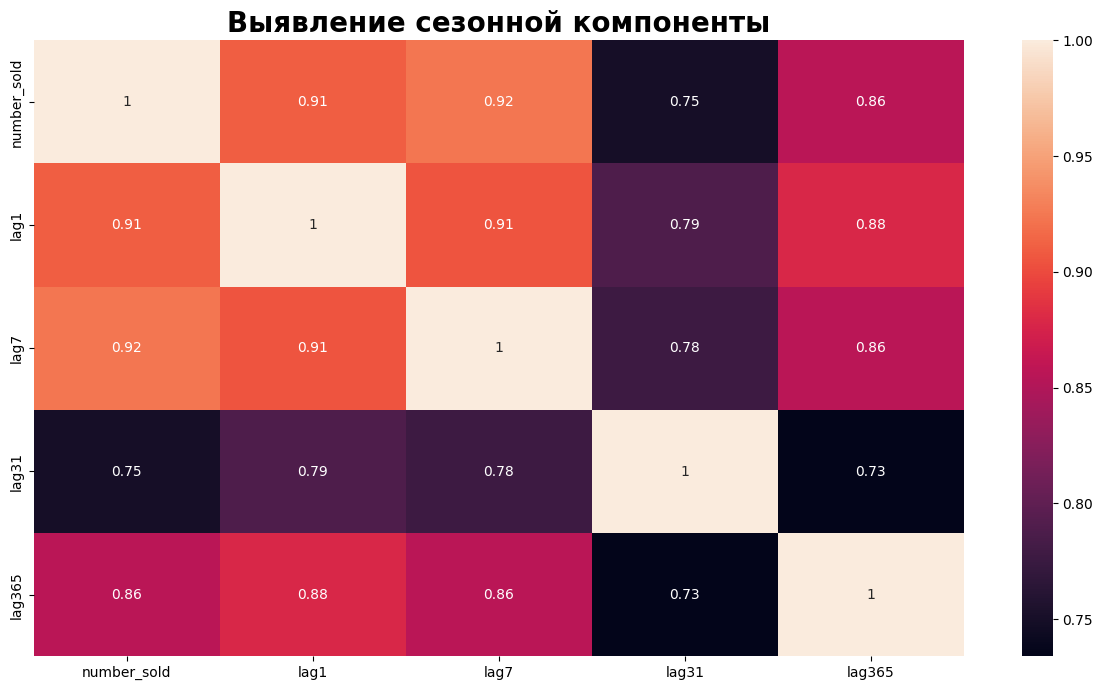

In [24]:
df['lag1'] = df['number_sold'].shift(1, axis = 0)
df['lag7'] = df['number_sold'].shift(7, axis = 0)
df['lag31'] = df['number_sold'].shift(31, axis = 0)
df['lag365'] = df['number_sold'].shift(365, axis = 0)

correlation = round(df.corr(),3)
sns.heatmap(correlation, annot = True)

plt.title('Выявление сезонной компоненты')
plt.show()

При построении данной матрицы корреояции можно определить сезонную компоненту (какое значение лага больше всего влияет на целевой признак)

В данном случае мы проверили дневную, недельную, месячную и гововую сезонность

Если посмотреть на значение коэффициента корреляции то можно понять, что в данных присутствует недельная сеознность которая лучше всего отражает свое влияние на целевую переменную (так как у нее наибольшее значение коэффициента корреляции)

Так же можно определить значение сезонности по графику ACF - но мы воспользовались методом определения сезонности с помощью матрицы корреляции.

Следовательно парамтер который мы будем ставить в модельм `SARIMA`, в качестве значения **s - 7**

### Подбор параметров p и q

Напомним - 

1. p - количество предыдущих значений которые учитываются для прогнозирования целевого признака
2. q - количество предыдущих значений ошибок которые будут учитываться для прогнозирования целевого признака

Чтобы подобрать эти значения надо воспользоваться графиком ACF и PACF 

**Для подбора p используем график ACF**
ACF - показывает корреляцию между текущим значением временного ряда и его лагами (предыдущими значениями) на различных отрезках временного промежутка 

Для подбора данного значения мы ищем на графике ACF значительные пики (которые выход за пределы значимости корреляции) - и лаги на которых наблюдаются значительные пики корреляции показывают на значение гиперпараметра `p`

In [25]:
# Удаляем значение лагов и оставляем только целевое значение 
columns = df.columns[1:]
df.drop(columns, axis = 1, inplace = True)

[]

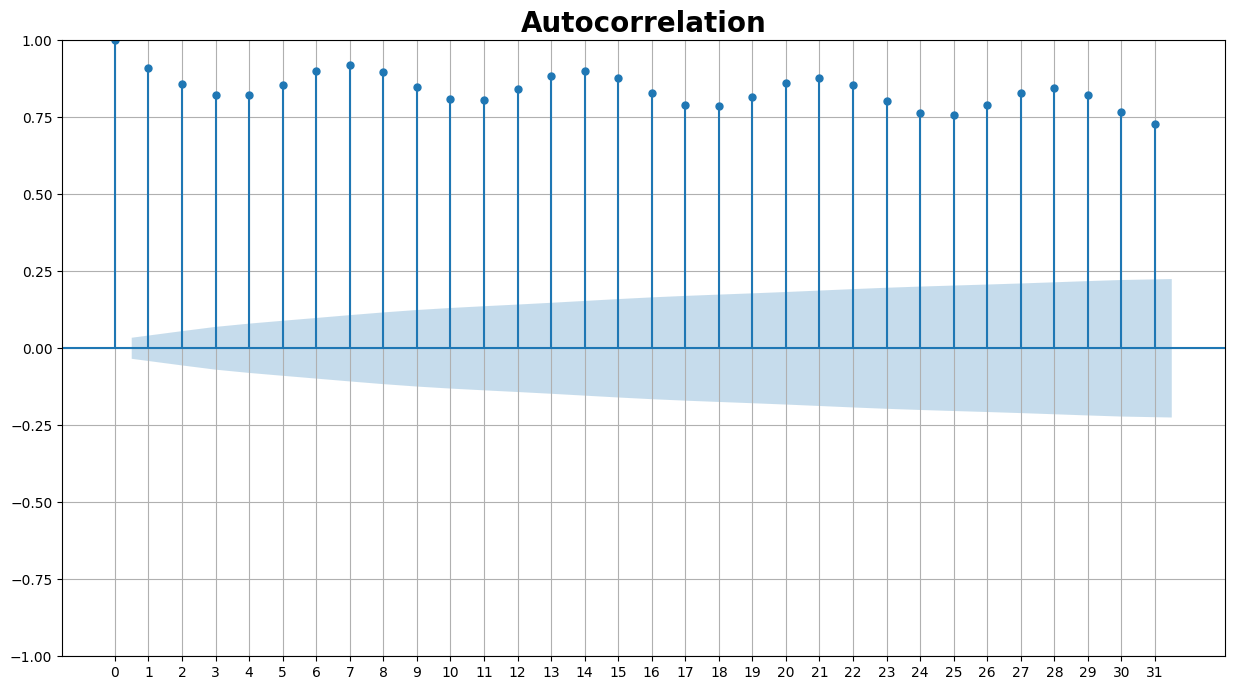

In [26]:
# Еще раз построим график ACF для подбора гиперпарамтера 'p'
plot_acf(df, lags = 31)

plt.xticks(range(0,32))
plt.grid()
plt.plot()

Так как у нас есть 2 значимых коэффициента корреляции (это значение 1 лага и 7 лага) то чтобы не сделать модель сложной мы ставим для модели гиперпараметр `p` со значением 1 

Следовательно **p = 1, d = 1**


Для подбра значения q вопользуемся построением графика PACF

График показывает корреляцию между текущим значением и лагом после удаления промежуточных значений лагов (котоыре расположены между этими лагами)

Чтобы подобрать параметр q так же надо посмотреть на данном графике значимые пики - это и будет значение `q`

[]

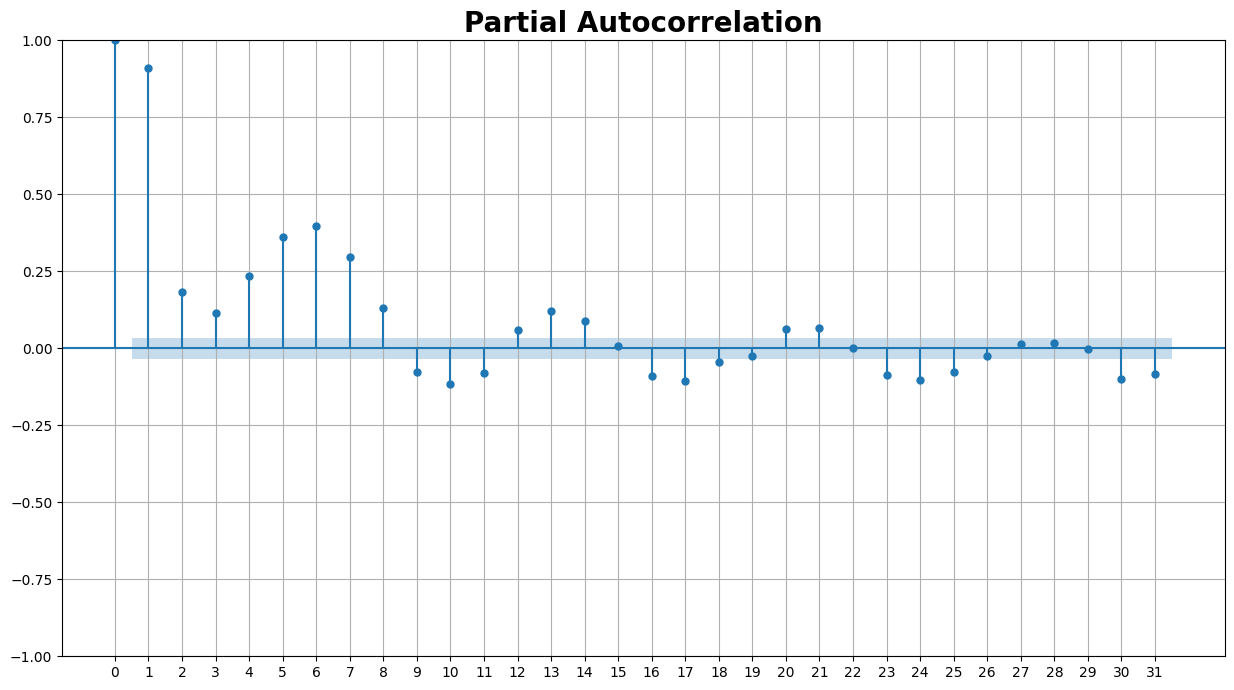

In [27]:
# Построим график PACF для подбора гиперпараметра q
plot_pacf(df, lags = 31)

plt.xticks(range(0,32))
plt.grid()
plt.plot()

По данному графику видно - что наиболее подходящее для нас значение - это значение 1 -> для параметра `q` лучше всего будет подобрать значение равное 1 

Таким образом на данный момент гиперпараметры для модели имеют следующие значения 
**p = 1, d = 1, q = 1**

### Подбор сезонных параметров для модели (P,D,Q)

Как говорилось ранее P D и Q выполнядют такие же функции как и обычные значения данный параметров, только эти параметры для сезонных компонент

Следовательно P - сколько предыдущих сезонных значений будет включено для описания сезонной зависимости в данных

Так как у нас сезонность - 7 дней (параметр s) то значение P и Q будет равнять 1 - то есть мы будем учитывать 1 лаг сезонного значения (то есть 1 предыдущее сезонной значение - с лагом 7)

Параметр D будет равен 0, так как после дифференцирования временного ряда 1 порядка ряд становиться стационарным -> нет необходимости в параметре D

Таким образом параметры для модели SARIMA будут следующие - **p = 1, d = 1, q = 1, P = 1, D = 0, Q = 1, s = 7**

### Построение модели SARIMA с подобранными гиперпараметрами

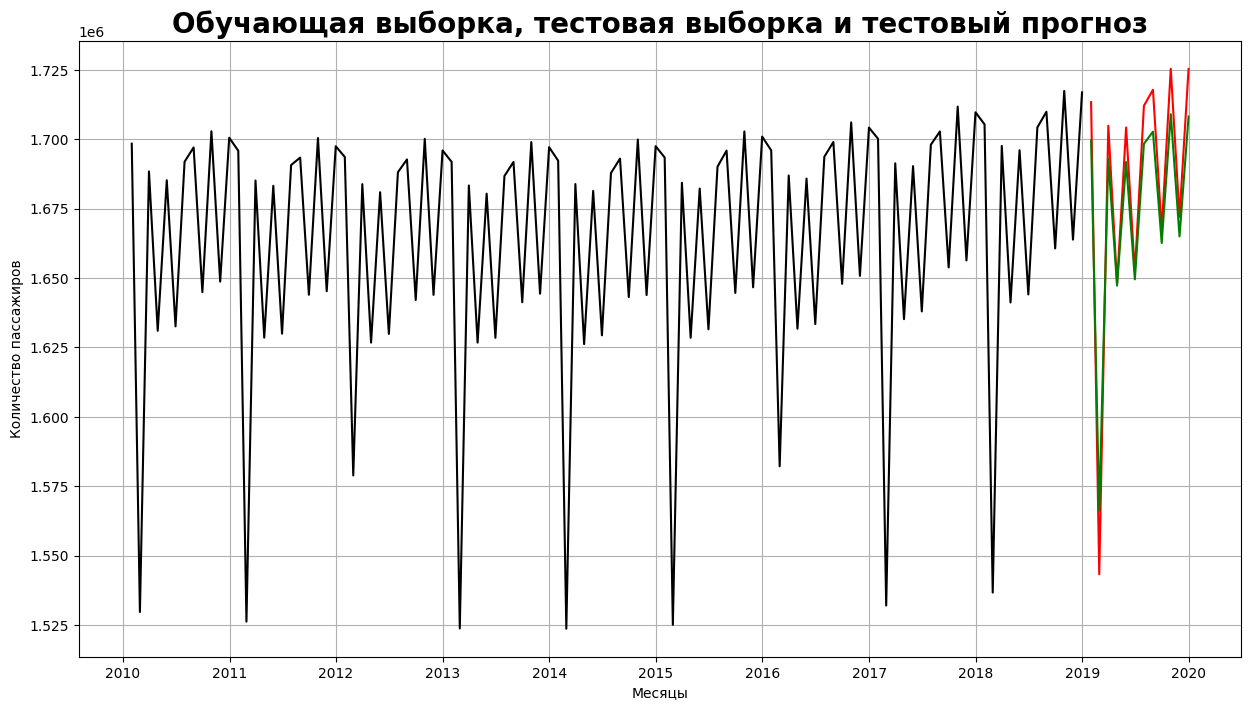

In [28]:
train = train.resample(rule = 'M').sum()
test = test.resample(rule = 'M').sum()

from statsmodels.tsa.statespace.sarimax import SARIMAX
 
model = SARIMAX(train, 
                order = (1,0,1),
                seasonal_order = (1, 0, 1, 12))

result = model.fit(disp=False)
predictions = result.predict(start=len(train), end=len(train) + len(test) - 1)

# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

In [29]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)

print('mae', mae)
print('mape', mape)
print('mse', mse)

mae 11531.608918442973
mape 0.006867515108273763
mse 172328564.55844364


Зеленая линия (предсказанные значения) достаточно точно соответствует красной линии (то есть фактическим тестовым значениям)

Так же есть оценивать метрики, то модель в среднем ошибается на  0.006% что является очень хорошим показателем точности модели, следовательно на этом и заканчивается построение модели SARIMA 
1. Был осуществлен анализ временного ряда
2. Подобраны гиперпараметры в ручную (с помощью анализа временных рядов и визуализации)
3. Была натренирована статистическая модель SARIMA

Далее добавим дополнительные факторы для модели и построим модель с помощью библиотеки skforecast - будут строится регрессионные модели - LinearRegression, RamdomForestRegressor, XGBoost

# Построение регрессионных моделей для временных рядов

Так как исходные данные - это данные за каждый день, а выше мы предсказывали и группировали данные за каждый месяц (так как модель статистическая и она долго обрабатывает данные за каждый день + с сезонностью в 365 дней) поэтому для статистической модели мы построили и натренировали модель на месячных количествах продаж 

Но в регрессионных моделях мы будем использовать данные за дневной период

Особенность работы регрессионных моделей в том, что к исходному набору данных надо будет добавлять дополнительные переменные (экзогенные) котоыре помогут модели предсказывать значение целевого признака

+ загрузим исходные данные
+ сделаем группировку по дню
+ добавим экзогенные переменные
+ натренируем регрессионные модели 

### Загрузка и преобразование данных

In [30]:
train = pd.read_csv('/kaggle/input/time-series-practice-dataset/train.csv')
test = pd.read_csv('/kaggle/input/time-series-practice-dataset/test.csv')

train.drop(['store', 'product'], axis = 1, inplace = True)
test.drop(['store', 'product'], axis = 1, inplace = True)

In [31]:
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')

train.index = train['Date']
test.index = test['Date']

train.drop('Date', axis = 1, inplace = True)
test.drop('Date', axis = 1, inplace = True)

train.index.name = None
test.index.name = None

In [32]:
train = train.resample(rule = 'D').sum()
test = test.resample(rule = 'D').sum()

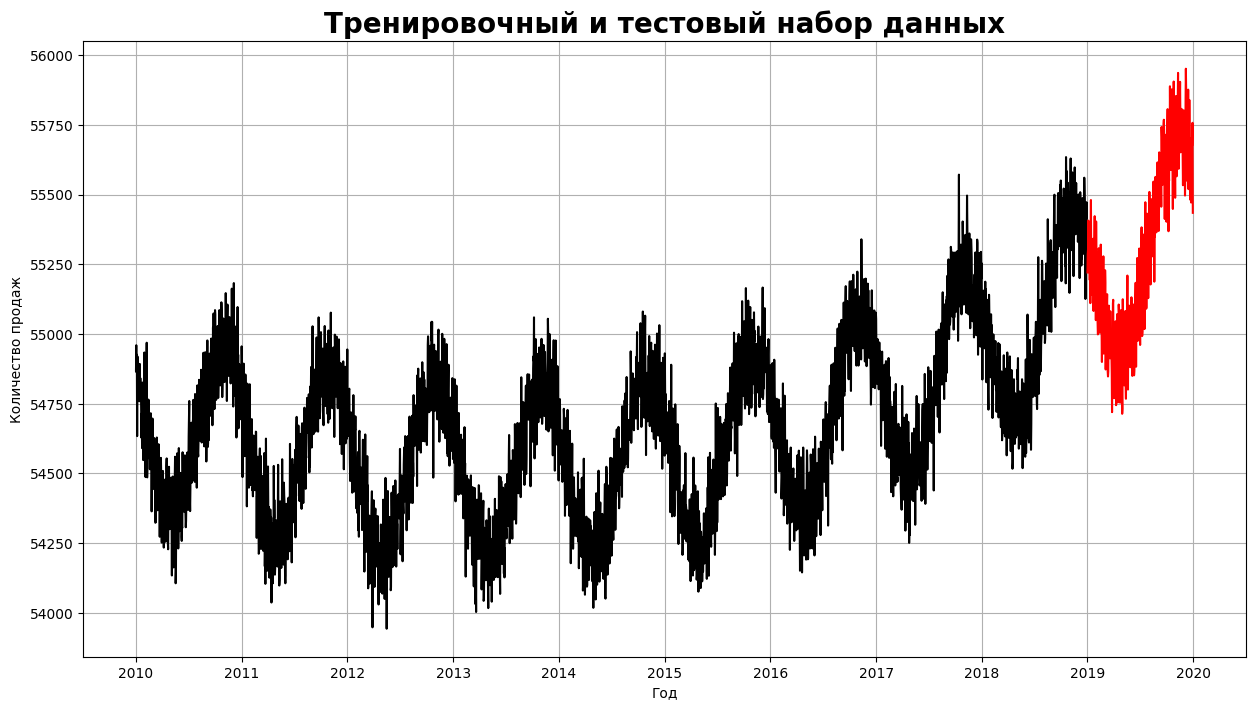

In [33]:
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')

plt.title('Тренировочный и тестовый набор данных')
plt.grid()
plt.ylabel('Количество продаж')
plt.xlabel('Год')
plt.show()

### Построение Линейной регрессии с помощью skforecast

Бибилиотека skforecast разработана специально для работы с временными рядами и мы будем строить модель линейной регрессии с помощью класса `ForecasterAutoreg`

Сначала будет строится модель без экзогенных переменных, но будет использован лаг 7, то есть модель для предсказания будет использовать данны еза последние 7 дней (то есть за последнюю неделю) в качестве предикторов

In [34]:
forecaster = ForecasterAutoreg(
    regressor = LinearRegression(),
    lags = 365)

forecaster.fit(train['number_sold'])
forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

**Описание вывода**

`Regressor` - укзазывает на то, какой регрессор использовался для прогнозирования (в нашем случае - Линейная регрессия)

`Lags` - какие задержки использует модель, для прогнозирования временного ряда (в данном примере от 1 до 7 лага)

`Transformer for y` - преобразование над y (тут его нет)

`Transformer for exog` - преобразование над внешними переменными (его нет)

`Window size` - указывает на размер окна, используемого для формирования признаков для временного ряда

`Weight function included` - используется функция взвешивания или нет

`Exogenous included` -используются внешние переменные в модели или нет (тут нет) - то есть предсказание осуществляется только за счет лагов во времени 

`Type of exogenous variable` - здесь отсутствие внешних переменных

`Exogenous variables names` - указывает на отсутсвие имен внешних переменных

`Training range` - диапазон дат, на которых была обучена модель

`Training index type` - указывает на то, что индекс в обучающем набор данных представлен в виде формата даты и времени

`Training index frequency` - как индексируются данные (здесь за каждый день)

`Regressor parameters` - набор параметров используемых в указанном регрессоре

`fit_kwargs` - показывает, что дополнительные параметры при обучении модели не использовались

`Creation date` - дата создания модели

`Last fit date` - дата последнего обучения модели

`Skforecast version` - версия библиотеки skforecast
`Python version` - верисия Python
`Forecaster id` - идентификатор если он был задан

После того как мы обучили модель линейной регрессии, будем прогноизровать тестовые данные (на год вперед)

### Прогнозирование с помощью линейной регрессии

In [35]:
steps = len(test)

y_pred = forecaster.predict(steps = steps)
y_pred.head()

2019-01-01    55305.096743
2019-01-02    55245.610214
2019-01-03    55350.235052
2019-01-04    55418.349070
2019-01-05    55415.591237
Freq: D, Name: pred, dtype: float64

### Построение графика предсказанных и фактических значений 

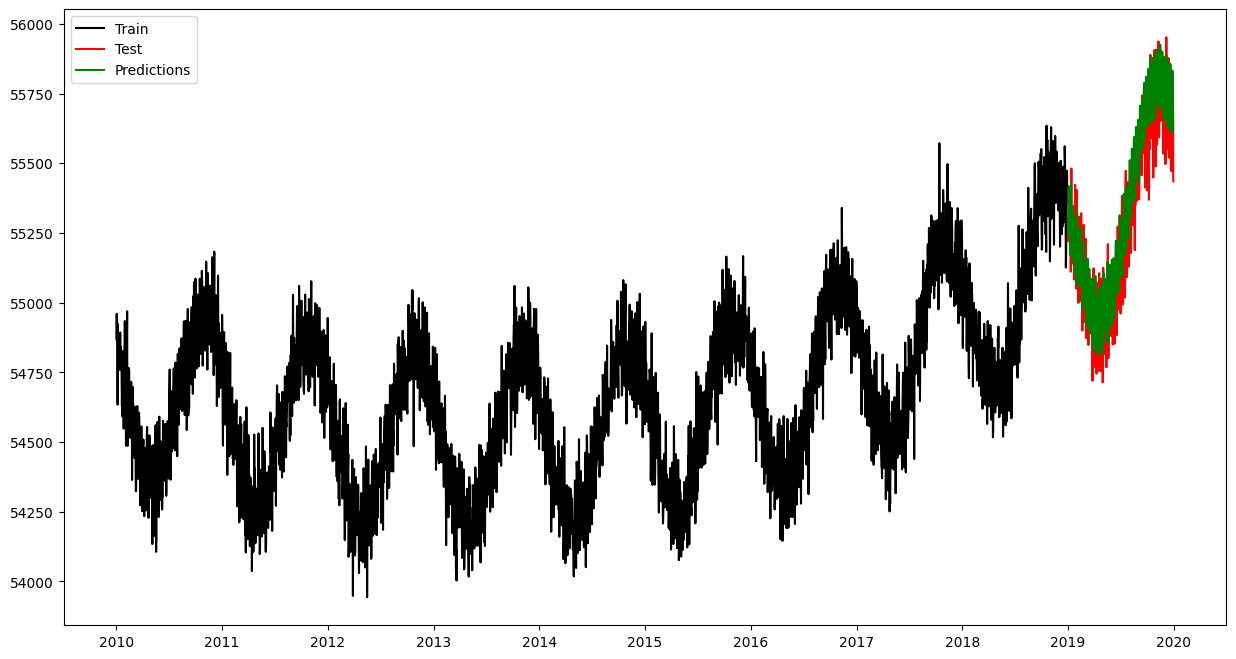

In [36]:
plt.plot(train, color = 'black', label = 'Train')
plt.plot(test, color = 'red', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'Predictions')

plt.legend()
plt.show()

По данной визуализации видно, что зеленый график достаточно точно соответствует красной линии (то есть фактическим значениям), поэтому по данной визуализации можно сказать что модель достаточно хорошо работает, но чтобы количественно оценить качество работы модели мы посчитам ее мтерики

### Оценка работы модели

In [37]:
mse = mean_squared_error(test, y_pred)
mae = mean_absolute_error(test, y_pred)
mape = mean_absolute_percentage_error(test, y_pred)

print('mae', mae)
print('mape', mape)
print('mse', mse)

mae 79.16608341800892
mape 0.0014314135043054844
mse 9693.387112876808


Модель ошибается всег на 0.001 процент, что является очень хорошим показателем точности модели, и если оценивать абсолютное значение, то модель ошибается на 79 единиц, что относительно продаж за день тоже является очень маленьким значением

### Backtesting модели

Означает обратное тестирование это один из методов оценивания временных рядов (кросс валидация только немного в другом виде)

+ Обратное тестирование предпоалает перемещение во времени шаг за шагом, на столько этапов, сколько необходимо (сколько задаст пользователь)
+ Это перекрестная проверка которая каждый раз осуществляется с дополнением данных
+ Модель обучается каждый раз перед тем как делать прогнозы
+ При таком методе проверки модель использует все доступные данные
+ Вместо случайного распределения данных (так как в обычной крос валидации) набор увеличивается последовательно, сохраняя временной порядок в данных (так как это основное условние временных рядов)

<img src="https://raw.githubusercontent.com/JoaquinAmatRodrigo/cienciadedatos.net/main/images/diagram-backtesting-refit.png">

<img src = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/cienciadedatos.net/main/images/backtesting_refit.gif'>

для того что бы провести backtesting модели - объеденим тренировочный и тестовый набор данных (так как мы не тренируем модель а проверяем ее точность)

In [38]:
df = pd.concat([train,test], axis = 0)
print(df.shape)
df.head()

(3652, 1)


,number_sold
2010-01-01,54870
2010-01-02,54960
2010-01-03,54863
2010-01-04,54926
2010-01-05,54634


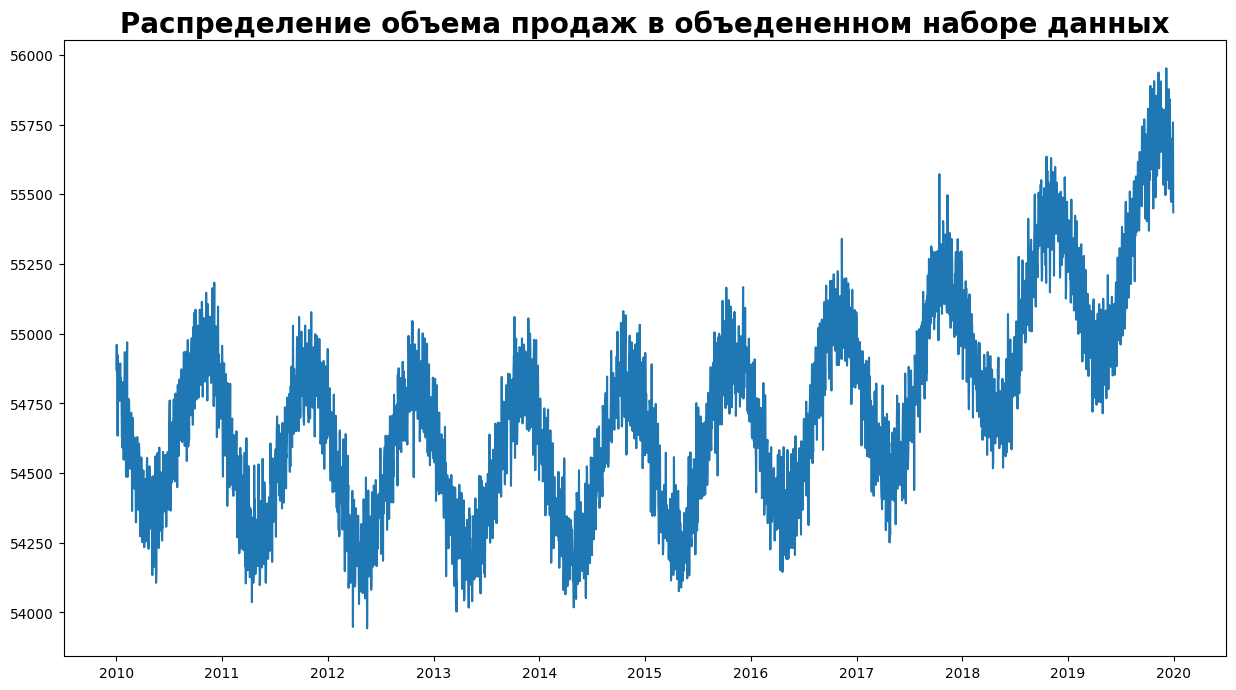

In [39]:
plt.plot(df)
plt.title('Распределение объема продаж в объедененном наборе данных')

plt.show()

как мы видим по данному графику - диапазон времени в объедененном наборе данных включает в себя как тестовый так и тренировочный набор данных, поэтому на этом наборе данных мы будем производить backtesting

**Как реализовывается обратное тестирование**
+ на первой итерации мы обучаем модель с использованием наблюдений выбранных для первоначального обучения (в данном случае мы будем брать первый год для обучения), затем следующий год (то есть 365 наблюдений) используются для проверки предсказаний первой модели
+ На второй итерации модель переобучается путем добавбления к исходному набору данных (с которого начиналось обучение) предыдущих валидайионных значений и следующие 365 значений (следующий год) становится тестовым набором для проверки
+ Этот процесс повторяется до тех пор, пока не будут использованы все доступные наблюдения

In [40]:
steps = 365 # шаг - годовой прогноз
n_backtesting = steps * 7 # проверка на 5 годах

meric, pred_backtest = backtesting_forecaster(forecaster = forecaster,
                                              y = df['number_sold'],
                                              initial_train_size = len(df) - n_backtesting,
                                              fixed_train_size = False,
                                              steps = steps,
                                              metric = 'mean_absolute_percentage_error',
                                              refit = True,
                                              verbose = True,
                                              show_progress = True)

print(f'Bactesting error: {meric}')                                    

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1097
Number of observations used for backtesting: 2555
    Number of folds: 7
    Number of steps per fold: 365
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-01-01 00:00:00 -- 2013-01-01 00:00:00  (n=1097)
    Validation: 2013-01-02 00:00:00 -- 2014-01-01 00:00:00  (n=365)
Fold: 1
    Training:   2010-01-01 00:00:00 -- 2014-01-01 00:00:00  (n=1462)
    Validation: 2014-01-02 00:00:00 -- 2015-01-01 00:00:00  (n=365)
Fold: 2
    Training:   2010-01-01 00:00:00 -- 2015-01-01 00:00:00  (n=1827)
    Validation: 2015-01-02 00:00:00 -- 2016-01-01 00:00:00  (n=365)
Fold: 3
    Training:   2010-01-01 00:00:00 -- 2016-01-01 00:00:00  (n=2192)
    Validation: 2016-01-02 00:00:00 -- 2016-12-31 00:00:00  (n=365)
Fold: 4
    Training:   2010-01-01 00:00:00 -- 2016-12-31 00:00:00  (n=2557)
    Validation: 2017-01-01 

  0%|          | 0/7 [00:00<?, ?it/s]

Bactesting error: 0.0016474000645335587


`forecaster:` Это объект forecaster, который вы хотите протестировать. Этот объект, вероятно, уже содержит предварительно настроенную модель прогнозирования.

`y:` представляет собой временной ряд, который будет использоваться для бэктестинга.

`initial_train_size:` Этот параметр указывает на размер начальной обучающей выборки. len(data) - n_backtesting означает, что для обучения используется весь временной ряд, за исключением последних n_backtesting точек.

`fixed_train_size:` Значение False указывает на то, что размер обучающей выборки не фиксирован и может меняться в процессе бэктестинга.

`steps:` Количество шагов вперед, на которые модель должна делать прогнозы.

`metric:` Метрика, используемая для оценки качества модели.

`refit:` Если True, это означает, что модель будет переобучена на начальной обучающей выборке перед проведением бэктестинга.

`verbose:` Если True, функция будет выводить дополнительную информацию в процессе выполнения, что полезно для отслеживания хода бэктестинга.

`show_progress:` Если True, в процессе выполнения будет отображаться индикатор прогресса.

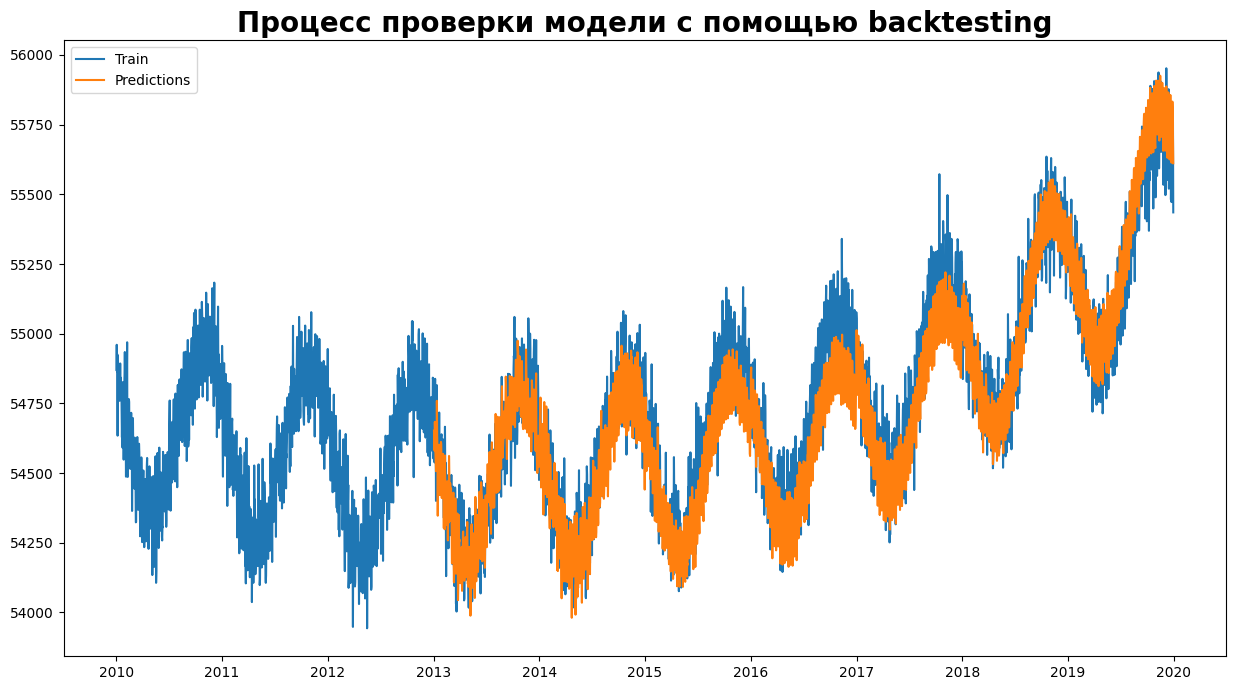

In [41]:
plt.plot(df, label = 'Train')
plt.plot(pred_backtest , label = 'Predictions')

plt.title('Процесс проверки модели с помощью backtesting')
plt.legend()
plt.show()

### Оценка важности признаков которые учитывает модель (лаги)

In [42]:
forecaster.get_feature_importances().sort_values(by = 'importance', ascending = False)

,feature,importance
17,lag_18,0.071540
7,lag_8,0.054784
0,lag_1,0.050974
2,lag_3,0.050275
54,lag_55,0.049219
...,...,...
120,lag_121,-0.048518
211,lag_212,-0.049818
74,lag_75,-0.054649
255,lag_256,-0.055404


Самой значимым коэффициентом в данной модели оказался lag_18

In [43]:
train

,number_sold
2010-01-01,54870
2010-01-02,54960
2010-01-03,54863
2010-01-04,54926
2010-01-05,54634
...,...
2018-12-27,55448
2018-12-28,55416
2018-12-29,55473
2018-12-30,55355


In [44]:
forecaster = ForecasterAutoreg(
    regressor = LinearRegression(),
    lags = 365)

forecaster.fit(train['number_sold'])

predictions = forecaster.predict_interval(steps = 365,
                                          interval = [1,99],
                                          n_boot = 500)

In [45]:
predictions.head()

,pred,lower_bound,upper_bound
2019-01-01,55305.096743,55119.263174,55479.087434
2019-01-02,55245.610214,55064.416757,55423.091117
2019-01-03,55350.235052,55167.282551,55539.515691
2019-01-04,55418.349070,55248.558461,55620.467848
2019-01-05,55415.591237,55238.574835,55579.821552


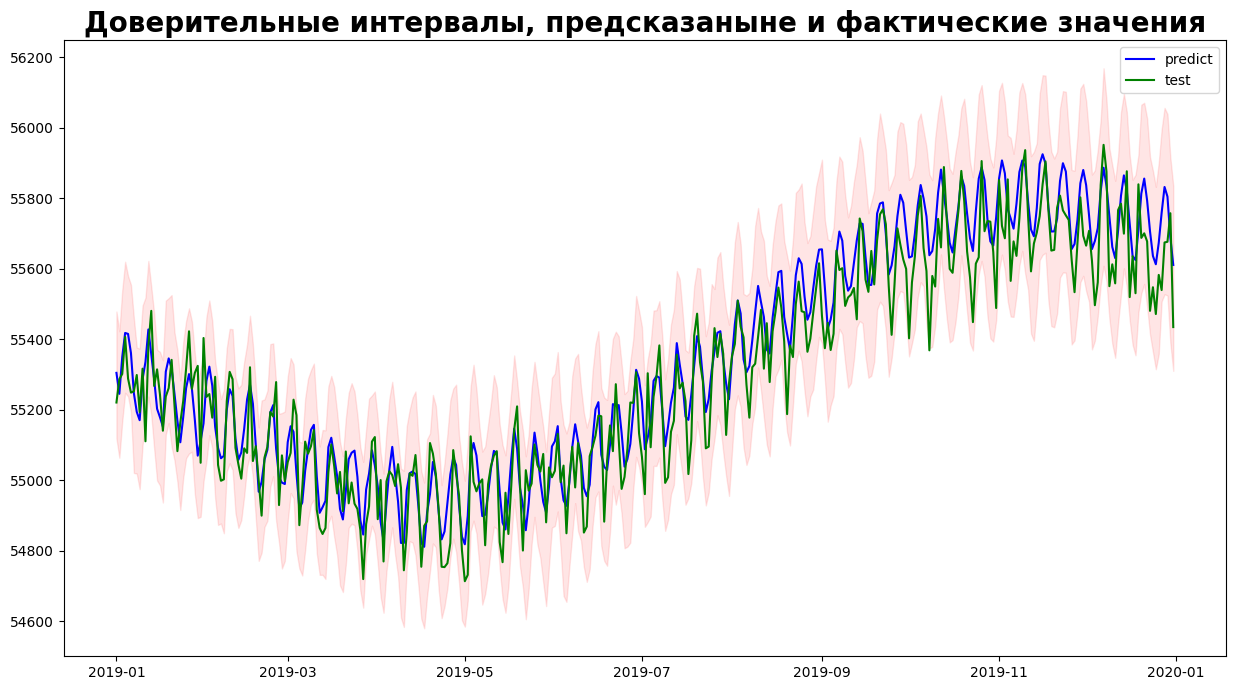

In [46]:
plt.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.1
)

plt.plot(predictions['pred'],color = 'blue', label = 'predict')
plt.plot(test, color = 'green', label = 'test')

plt.title('Доверительные интервалы, предсказаныне и фактические значения')
plt.legend()
plt.show()

Данный график показывает и визуализирует доверительные интервалы для нашего предсказания

+ `.predict_interval` - используется для расчеты дверительных интервалов прогноза
+ `interval` - задает процентили для расчета интервалов доверия прогнозов (в данном случае выбран интервал от 1 до 99 - то есть очень широкий интервал доверия) Это означает что модель предоставит оценки, в которых с 99% уверенностью можно ожидать, что будущее значение окажется внутри заданного интервала
+ `n_boot` - указывает на количество бутстрап выборок, используемых для расчета интервалов 

In [47]:
predictions['pred'].to_csv('Предсказанные значения.csv')